Try the negative learning rule variations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [2]:
dt = 0.001
seed = 0

ens_params = dict(encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[250, 300, 300, 250])


def stim_func(t):
    if (t % 1) > 0.5:
        return 0.3
    else:
        return -0.3


lr = -5e-9
pre_nrn = 4

In [3]:
class FakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, out_neurons=2, theta_tau=1.0,
                 sample_every=0.1, start_weights=None):
        self.kappa = learning_rate * dt
        assert start_weights is not None
        self.omega = start_weights.copy()
        self.in_nrns = in_neurons
        self.lowpass = nengo.Lowpass(theta_tau).make_step(out_neurons, out_neurons, dt, None)
        self.weight_history = []
        self.period = sample_every / dt

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        theta = self.lowpass(t, out_rates) * 1.4
        self.omega += np.outer(self.kappa * out_rates * (out_rates - theta), in_rates)
        #np.fill_diagonal(self.omega, 0.)

        if (t / dt % self.period) < 1:
            self.weight_history.append(self.omega.copy())

        return np.dot(self.omega, in_rates)

In [4]:
with nengo.Network() as fake_model:
    sin = nengo.Node(stim_func)
    
    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    fake_bcm = FakeBCM(in_neurons=pre_nrn, out_neurons=pre_nrn, learning_rate=lr, start_weights=np.zeros((4, 4)))
    learn = nengo.Node(fake_bcm.bcm_func, size_in=pre_nrn+pre_nrn, size_out=pre_nrn)

    nengo.Connection(sin, ens)

    nengo.Connection(ens.neurons, learn[:pre_nrn], synapse=0.05)
    nengo.Connection(ens.neurons, learn[pre_nrn:], synapse=0.05)
    nengo.Connection(learn, ens.neurons, synapse=None)

    fake_model.p_in = nengo.Probe(sin, synapse=None)
    fake_model.p_nd = nengo.Probe(learn, synapse=0.01)
    fake_model.p_out = nengo.Probe(ens, synapse=0.01)
    fake_model.p_spikes = nengo.Probe(ens.neurons, synapse=None)
    fake_model.p_rates = nengo.Probe(ens.neurons, synapse=0.005)
    fake_model.p_theta = nengo.Probe(ens.neurons, synapse=1.0)

In [5]:
with nengo.Simulator(fake_model) as fake_sim:
    fake_sim.run(10)

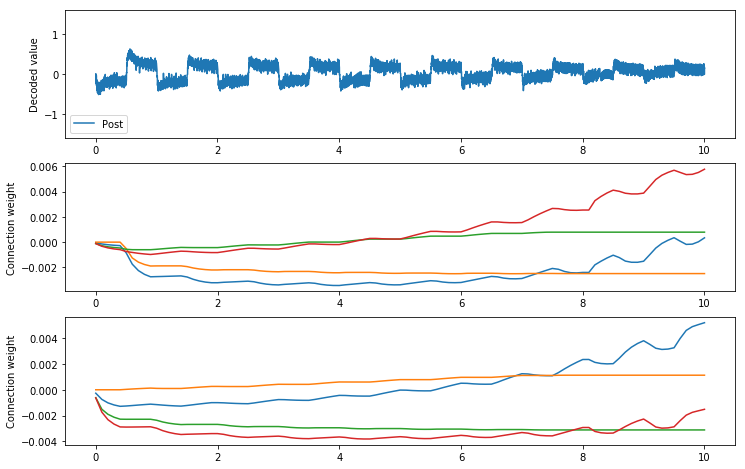

In [6]:
w_hist = np.array(fake_bcm.weight_history)
w_hist_trange = np.concatenate(([0], fake_sim.trange(dt=0.1),))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(fake_sim.trange(), fake_sim.data[fake_model.p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.ylabel("Connection weight")
plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1])
plt.ylabel("Connection weight")

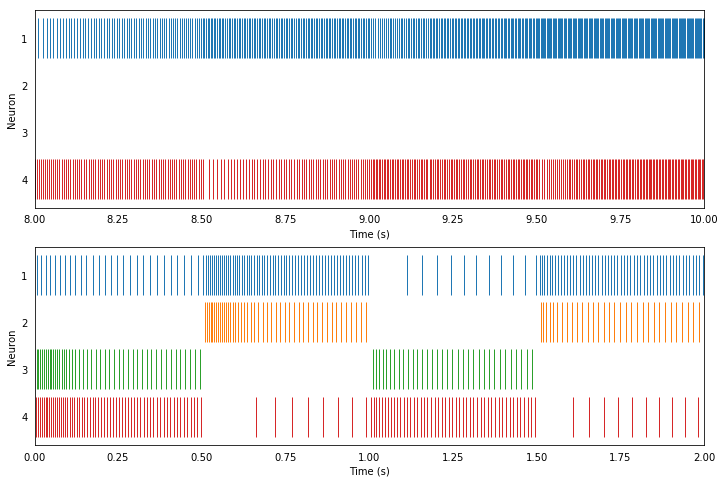

In [7]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(fake_sim.trange()[-win:], fake_sim.data[fake_model.p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

ax = plt.subplot(2, 1, 2)
rasterplot(fake_sim.trange()[:win], fake_sim.data[fake_model.p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

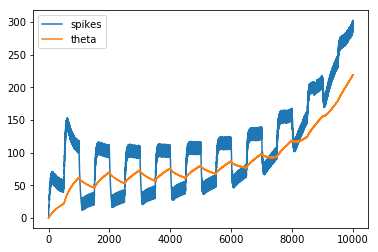

In [8]:
plt.plot(nengo.Lowpass(0.05).filt(fake_sim.data[fake_model.p_spikes][:, 0]), label="spikes")
plt.plot(fake_sim.data[fake_model.p_theta][:, 0], label="theta")
plt.legend()

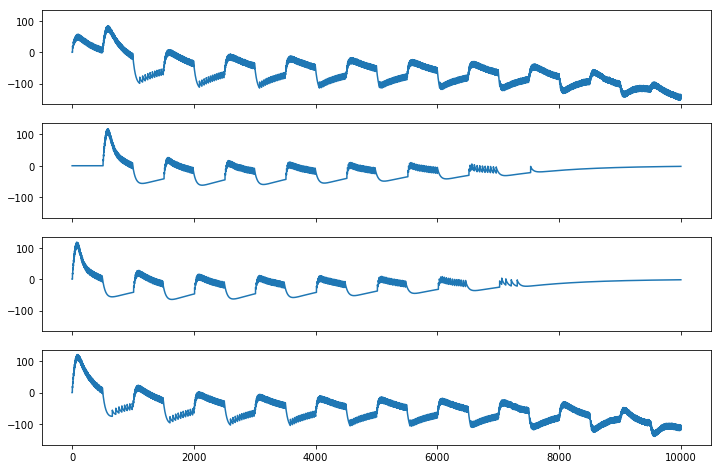

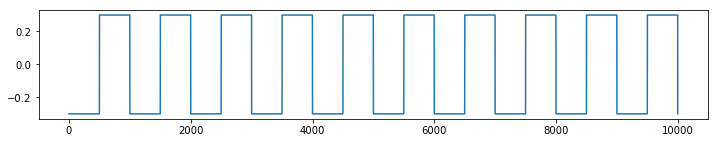

In [9]:
f, axes = plt.subplots(pre_nrn, sharex=True, sharey=True, figsize=(12, 8))

for nrn in range(pre_nrn):
    axes[nrn].plot(nengo.Lowpass(0.05).filt(fake_sim.data[fake_model.p_spikes][:, nrn]) - fake_sim.data[fake_model.p_theta][:, nrn]*2)

plt.figure(figsize=(12, 2))
plt.plot(fake_sim.data[fake_model.p_in])

In [10]:
class AltFakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, out_neurons=2, theta_tau=1.0,
                 sample_every=0.1, start_weights=None):
        self.kappa = learning_rate * dt
        assert start_weights is not None
        self.omega = start_weights.copy()
        self.in_nrns = in_neurons
        self.lowpass = nengo.Lowpass(theta_tau).make_step(out_neurons, out_neurons, dt, None)
        self.weight_history = []
        self.period = sample_every / dt

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        theta = self.lowpass(t, out_rates)
        self.omega += np.outer(self.kappa * out_rates * (theta - out_rates), in_rates)

        if (t / dt % self.period) < 1:
            self.weight_history.append(self.omega.copy())

        return np.dot(self.omega, in_rates)

In [11]:
with nengo.Network() as alt_model:
    sin = nengo.Node(stim_func)
    
    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    alt_bcm = AltFakeBCM(in_neurons=pre_nrn, out_neurons=pre_nrn, learning_rate=lr, start_weights=np.zeros((4, 4)))
    learn = nengo.Node(alt_bcm.bcm_func, size_in=pre_nrn+pre_nrn, size_out=pre_nrn)

    nengo.Connection(sin, ens)

    nengo.Connection(ens.neurons, learn[:pre_nrn], synapse=0.05)
    nengo.Connection(ens.neurons, learn[pre_nrn:], synapse=0.05)
    nengo.Connection(learn, ens.neurons, synapse=None)

    alt_model.p_in = nengo.Probe(sin, synapse=None)
    alt_model.p_nd = nengo.Probe(learn, synapse=0.01)
    alt_model.p_out = nengo.Probe(ens, synapse=0.01)
    alt_model.p_spikes = nengo.Probe(ens.neurons, synapse=None)
    alt_model.p_rates = nengo.Probe(ens.neurons, synapse=0.005)
    alt_model.p_theta = nengo.Probe(ens.neurons, synapse=1.0)

In [12]:
with nengo.Simulator(alt_model) as alt_sim:
    alt_sim.run(10)

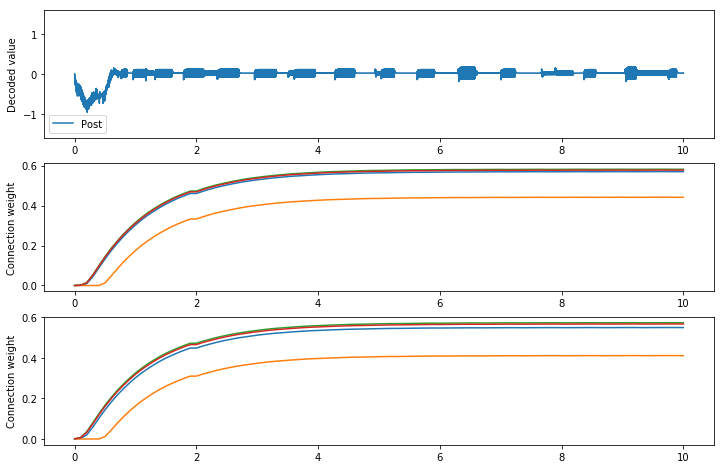

In [13]:
w_hist = np.array(alt_bcm.weight_history)
w_hist_trange = np.concatenate(([0], alt_sim.trange(dt=0.1),))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(alt_sim.trange(), alt_sim.data[alt_model.p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.ylabel("Connection weight")
plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1])
plt.ylabel("Connection weight")

In [31]:
w_hist.shape

(0,)